In [1]:
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
notebook_dir = os.getcwd()
sys.path.append(notebook_dir)
from model import Model
from dataloader import DataLoader

In [2]:
logging.basicConfig(
    filename="merge.log",
    filemode="w",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s" 
)

In [3]:
def run_experiment(args):
    arr_len, S, seed = args
    dataloader = DataLoader(arr_len=arr_len, seed=seed)
    array = dataloader.generate_data()

    logging.info(f"Starting sort for arr_len={arr_len} with S={S}")
    model = Model(array, S)
    logging.info(f"Completed sort for arr_len={arr_len} with S={S}")

    model.train()

    return {
        "Array Length": arr_len,
        "Execution Time": model.execution_time,
        "Threshold": S,
        "Key Comparisons": model.key_cmp
    }

In [4]:
# TEST
arr_len = 30
S=3

dataloader = DataLoader(arr_len=arr_len)
array = dataloader.generate_data()

model = Model(array, S)

print(model.array)
model.train()
print(model.array)

[28  7 29 17  4  5 30  2 16 23 20 25  9  6 24 18 19 22 13  8 15 26 10 21
 14 11 12 27  3  1]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]


In [5]:
np.random.seed(42)

seed_values = np.random.randint(0, 100000, size=20).tolist()

base_experiments = [(10_000_000, 7), (10_000_000, 1)]
experiments = [(size, param, seed) for seed in seed_values for (size, param) in base_experiments]

with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(run_experiment, experiments), total=len(experiments), desc="Processing Arrays"))

print("Execution complete")

df_results = pd.DataFrame(results, columns=["Array Length", "Threshold", "Execution Time", "Key Comparisons"])
df_results.to_parquet("comparison.parquet")

Processing Arrays: 100%|██████████| 40/40 [01:21<00:00,  2.05s/it]


Execution complete


In [6]:
# Compute the average and standard deviation for each (Array Length, Threshold)
df_avg = df_results.groupby(["Array Length", "Threshold"]).agg(
    Execution_Time_Mean=("Execution Time", "mean"),
    Execution_Time_Std=("Execution Time", "std"),
    Key_Comparisons_Mean=("Key Comparisons", "mean"),
    Key_Comparisons_Std=("Key Comparisons", "std")
).reset_index()

# Map Threshold to Algorithm Name
df_avg["Algorithm"] = df_avg["Threshold"].map({1: "Merge Sort", 7: "Hybrid Sort"})
df_avg

,Array Length,Threshold,Execution_Time_Mean,Execution_Time_Std,Key_Comparisons_Mean,Key_Comparisons_Std,Algorithm
0,10000000,1,80.803451,0.215999,220100893.4,1450.614367,Merge Sort
1,10000000,7,74.699440,0.315939,221108739.1,2366.677171,Hybrid Sort


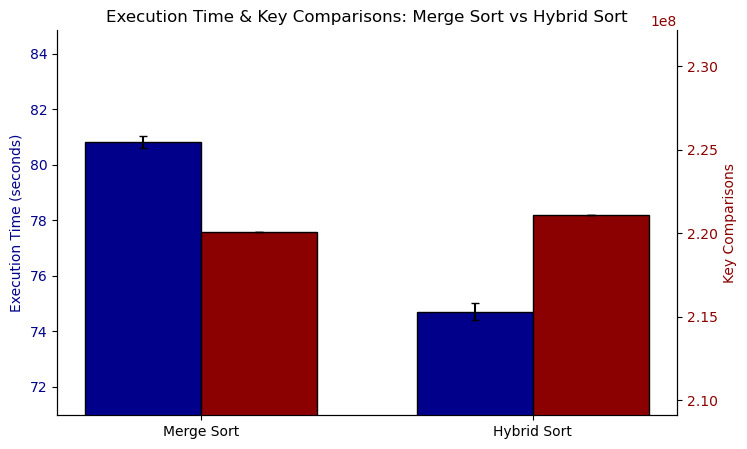

In [8]:
bar_width = 0.35  
x = np.arange(len(df_avg["Algorithm"]))  

colors = ["darkblue", "darkred"]  

# Create figure
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.bar(
    x - bar_width/2, df_avg["Execution_Time_Mean"], bar_width, 
    yerr=df_avg["Execution_Time_Std"], capsize=3, 
    color=colors[0], edgecolor='black', label="Execution Time", zorder=3
)
ax1.set_ylabel("Execution Time (seconds)", color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])
ax1.set_ylim(df_avg["Execution_Time_Mean"].min() * 0.95, df_avg["Execution_Time_Mean"].max() * 1.05)
ax1.grid(False)  # Disable grid on ax1

ax2 = ax1.twinx()
ax2.bar(
    x + bar_width/2, df_avg["Key_Comparisons_Mean"], bar_width, 
    yerr=df_avg["Key_Comparisons_Std"], capsize=3, 
    color=colors[1], edgecolor='black', label="Key Comparisons", zorder=2
)
ax2.set_ylabel("Key Comparisons", color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])
ax2.set_ylim(df_avg["Key_Comparisons_Mean"].min() * 0.95, df_avg["Key_Comparisons_Mean"].max() * 1.05)
ax2.grid(False)

ax1.set_xticks(x)
ax1.set_xticklabels(df_avg["Algorithm"])

plt.title("Execution Time & Key Comparisons: Merge Sort vs Hybrid Sort")

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()